# SASRec model

**Table of Contents**

* Prepare data
* Model description
* Recommendations
* RecTools implementation
    * Additional details
* Model application
    * Additional details
* Under the hood: Dataset processing
* Under the hood: Transformer layers




In [1]:
import numpy as np
import os
import pandas as pd
import torch

from lightning_fabric import seed_everything
from pathlib import Path

from rectools import Columns
from rectools.dataset import Dataset
from rectools.models.sasrec import SasRecModel

# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Prepare data

We are using KION dataset for this tutorial. The data was gathered from the users of MTS KION video streaming platform. To make recommendations only user-item interactions are required, as SASRec implementation does not support user and item features.

In [2]:
%%time
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_en.zip -O data_en.zip
!unzip -o data_en.zip
!rm data_en.zip

Archive:  data_en.zip
  inflating: data_en/items_en.csv    
  inflating: __MACOSX/data_en/._items_en.csv  
  inflating: data_en/interactions.csv  
  inflating: __MACOSX/data_en/._interactions.csv  
  inflating: data_en/users_en.csv    
  inflating: __MACOSX/data_en/._users_en.csv  
CPU times: user 83.8 ms, sys: 44.4 ms, total: 128 ms
Wall time: 5.51 s


In [3]:
# Download dataset
DATA_PATH = Path("data_en")
items = pd.read_csv(DATA_PATH / 'items_en.csv', index_col=0)
interactions = (
    pd.read_csv(DATA_PATH / 'interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": Columns.Datetime})
)
print(interactions.shape)
interactions.head(2)

(5476251, 5)


,user_id,item_id,datetime,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0


In [4]:
# Process interactions
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)
interactions = interactions[["user_id", "item_id", "datetime", "weight"]]
print(interactions.shape)
interactions.head(2)

(5476251, 4)


,user_id,item_id,datetime,weight
0,176549,9506,2021-05-11,3
1,699317,1659,2021-05-29,3


In [5]:
# Create dataset 
dataset = Dataset.construct(
    interactions_df=interactions,
)

# Model description

SASRec is a transformer-based sequential model with unidirectional attention mechanism and "Shifted Sequence" training objective. 

As an input SASRec takes user sequences, containig previous user interaction history. Description of how they are created from user-item interactions can be found in "Under the hood: Dataset processing" part. Item embeddings from these sequences are fed to multi-head self-attention to acquire user sequence latent represenation. After one or several stacked attention blocks, resulting embeddings are used to predict next item.

In contrust to BERT4Rec, another transformer-based recommender model, SASRec is a causal model. It applies causal mask to enforce model focus solely on past interactions.


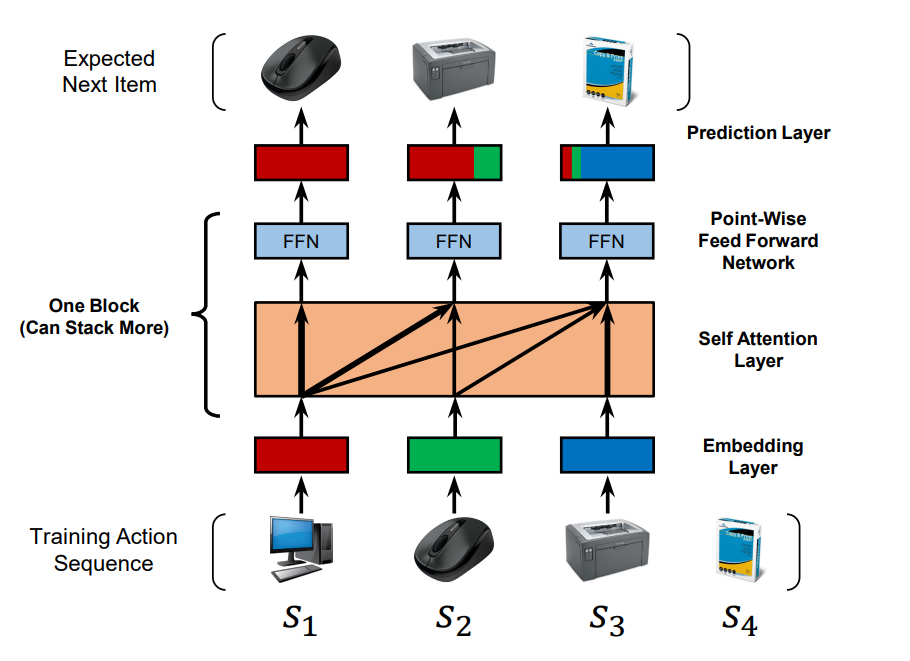

# Recommendations

After that implicit ranker is applied to make recommendations. Implicit ranker bases on implicit library matrix factorization topk method that:
* Receives as input:
    * Item embeddings
    * User sequence latent embeddings. Similarly to train stage, user sequence item embeddings are passed through transformer blocks and layer normalization to receive latent representation.
* Finds relevanace of each item by multiplication of user and item embeddings
* Returns items within topk with greates relevance

For u2i recommendations DOT distance is applied to find item relevance, for i2i - COSINE

# RecTools implementation
Current implementation uses architecture offered by the authors of original article. In contrast to original model, only cross-entropy loss is supported and no negative sampling is provided. However, in the future versions more loss functions are expected.

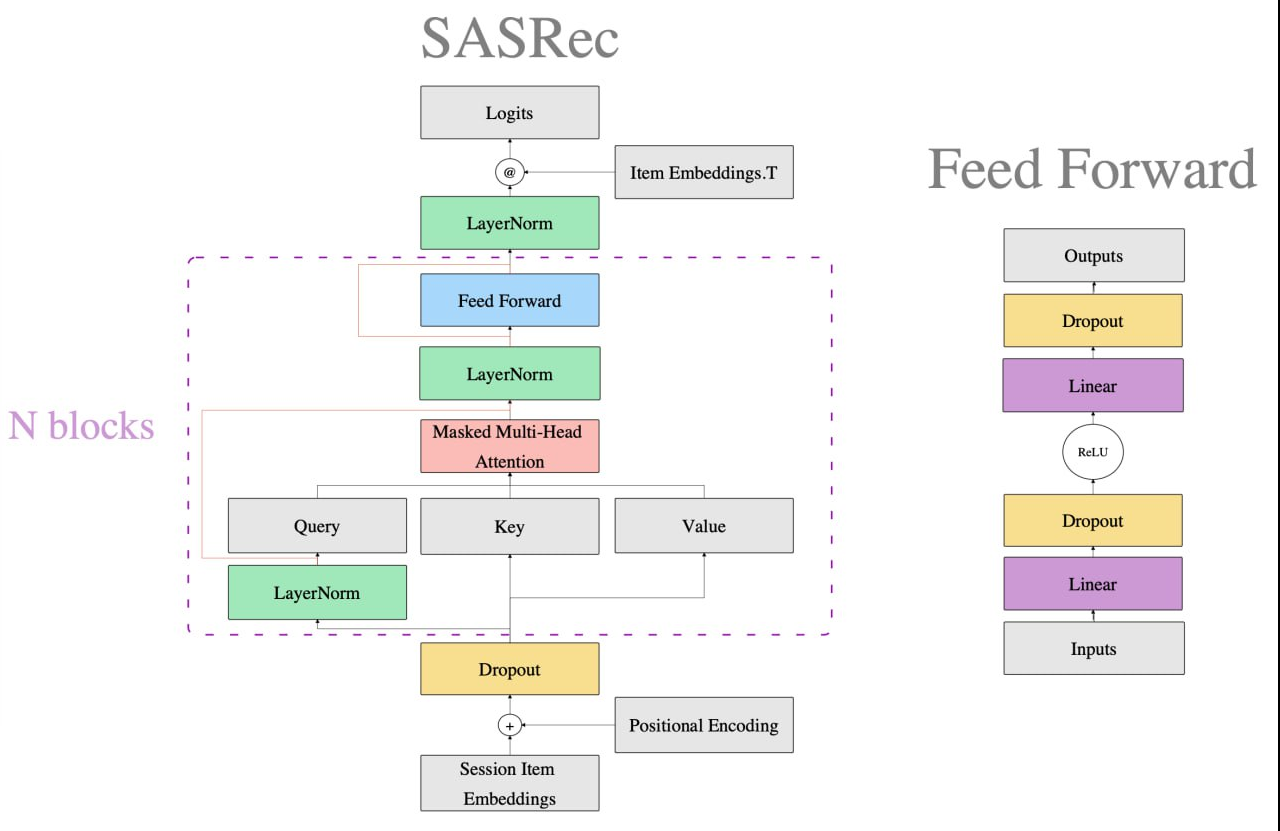

### Additional details
1. Xavier normal initialization for model parameters
2. Adam optimizer with betas=(0.9, 0.98) is used
3. Masked multi-head attention uses attention and timeline mask
4. Cross-entropy loss without reduction is applied, ignoring 0 index not to take into account pad element. 

# Model Application

In [6]:
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

Seed set to 60


60

In [7]:
# Prepare test user
test_user = [176549] 
print(interactions[interactions["user_id"] == test_user[0]].shape)
interactions[interactions["user_id"] == test_user[0]].head(2)

(82, 4)


,user_id,item_id,datetime,weight
0,176549,9506,2021-05-11,3
3815,176549,15469,2021-05-25,3


* Specify latent embeddings size with `n_factors`
* Specify number of self-attention blocks with `n_blocks` 
* Specify number of attention heads with `n_heads`
* Specify `dropout_rate`
* Specify whether positional encoding should be used with `use_pos_emb`
* Specify maximum length of user-item interaction history with `session_maxlen`
* Specify `lr` for learning rate 
* Specify `batch_size`
* Specify `epochs` for number of model training epochs

In [8]:
factors=128
session_maxlen=32
model = SasRecModel(
    n_factors=factors, 
    n_blocks=2,
    n_heads=1,
    dropout_rate=0.2,
    use_pos_emb=True,
    session_maxlen=session_maxlen,
    lr=1e-3,
    batch_size=128,
    epochs=5,
    device="cuda:1",
    loss="softmax",
    verbose=1,
    deterministic=True,
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/home/maspirina1/Tasks/RecTools/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [9]:
%%time
model.fit(dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type                           | Params
---------------------------------------------------------------
0 | loss_func   | CrossEntropyLoss               | 0     
1 | torch_model | TransformerBasedSessionEncoder | 2.1 M 
---------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.207     Total estimated model params size (MB)
/data/home/maspirina1/Tasks/RecTools/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=143` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 10min 11s, sys: 15 s, total: 10min 26s
Wall time: 10min 13s


In [10]:
%%time
recos = model.recommend(
    users = test_user, 
    dataset = dataset,
    k = 3,
    filter_viewed = True,
    on_unsupported_targets="warn",
)
recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["user_id", "rank"])

100%|██████████| 1/1 [00:00<00:00, 28.36it/s]

CPU times: user 670 ms, sys: 1.19 s, total: 1.86 s
Wall time: 342 ms


,user_id,item_id,score,rank,title_orig
0,176549,11749,2.834625,1,Incredibles 2
1,176549,7310,2.768771,2,Despicable Me 2
2,176549,15266,2.686491,3,Monsters University


### Additional details
It may happen that SASRec filters out users with less than 2 interactions during train stage, as target is a shifted interaction sequence. However, it is still possible to make recommendations for user with one interaction in history if this interaction item was present at training.

As an example consider user 324373, for whom there is only one interaction in the dataset.

In [11]:
# Prepare test user with 1 interaction
test_user_recs = [324373] 
print(interactions[interactions["user_id"] == test_user_recs[0]].shape)
interactions[interactions["user_id"] == test_user_recs[0]]

(1, 4)


,user_id,item_id,datetime,weight
2493287,324373,10440,2021-06-24,3


In [12]:
%%time
recos = model.recommend(
    users = test_user_recs, 
    dataset = dataset,
    k = 3,
    filter_viewed = True,
    on_unsupported_targets="warn",
)
recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["user_id", "rank"])

100%|██████████| 1/1 [00:00<00:00, 232.91it/s]

CPU times: user 580 ms, sys: 690 ms, total: 1.27 s
Wall time: 97.7 ms


,user_id,item_id,score,rank,title_orig
0,324373,15297,5.894632,1,Klinika schast'ya
1,324373,9728,4.081971,2,Wrath of Man
2,324373,13865,4.080128,3,V2. Escape from Hell


Another case is when user had interactions, but all of the items were not present at the train stage. This may happen due to several reasons:
* Other users with this item were excluded due to lack of interactions
* User sequence exceeded `session_maxlen` and was shortened 

If user does not have interactions containg items, which model knows, this user will not get recommendations.

In [13]:
# Prepare test user with items unknown by the model
test_user_no_recs = [14630] 
print(interactions[interactions["user_id"] == test_user_no_recs[0]].shape)
interactions[interactions["user_id"] == test_user_no_recs[0]].head(2)

(1, 4)


,user_id,item_id,datetime,weight
2393877,14630,8871,2021-03-28,3


Flag `on_unsupported_target` allows to monitor the number of users without any known items.

Flag options:
* "ignore" - skip such users, show warning with the number of cold users.
* "warn" - skip such users, show warning with the number of cold users and that cold users are not supported.
* "raise" - stop recommendation procedure.

In [29]:
%%time
recos = model.recommend(
    users = test_user_no_recs, 
    dataset = dataset,
    k = 3,
    filter_viewed = True,
    on_unsupported_targets="warn",
)
recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["user_id", "rank"])

CPU times: user 61.4 ms, sys: 73 µs, total: 61.5 ms
Wall time: 60.2 ms


/data/home/maspirina1/Tasks/RecTools/rectools/models/sasrec.py:507: UserWarning: 1 target users were considered cold
            because of missing known items
  warnings.warn(explanation)
/data/home/maspirina1/Tasks/RecTools/rectools/models/base.py:406: UserWarning: 
                Model `<class 'rectools.models.sasrec.SasRecModel'>` doesn't support recommendations for cold users,
                but some of given users are cold: they are not in the `dataset.user_id_map`
            
  warnings.warn(explanation)


,user_id,score,rank,item_id,title_orig


# Links
1. SASRec original paper: [Self-Attentive Sequential Recommendation](https://arxiv.org/abs/1808.09781)
2. [Turning Dross Into Gold Loss: is BERT4Rec really better than SASRec?](https://arxiv.org/abs/2309.07602)
3. [gSASRec: Reducing Overconfidence in Sequential Recommendation Trained with Negative Sampling](https://arxiv.org/pdf/2308.07192)

# Under the hood: Dataset processing


Preprocessing steps will be shown using toy dataset:

<table>
    <tr>
        <th> user_id </th>
        <th> item_id </th>
        <th> weight </th> 
        <th> datetime </th>
    </tr>
    <tr>
        <td>u1</td>
        <td>i1</td>
        <td>0.1</td>
        <td>2021-09-09</td>
    </tr>
        <tr>
        <td>u2</td>
        <td>i1</td>
        <td>0.3</td>
        <td>2021-09-09</td>
    </tr>
        <tr>
        <td>u2</td>
        <td>i3</td>
        <td>0.2</td>
        <td>2021-09-05</td>
    </tr>
        <tr>
        <td>u1</td>
        <td>i2</td>
        <td>0.3</td>
        <td>2021-09-07</td>
    </tr>
        <tr>
        <td>u3</td>
        <td>i2</td>
        <td>0.4</td>
        <td>2021-09-05</td>
    </tr>
        <tr>
        <td>u1</td>
        <td>i3</td>
        <td>0.5</td>
        <td>2021-09-08</td>
    </tr>
</table>

1. Filter out users with less than 2 interactions in train dataset. The model uses shifted user interactions to make next item prediction, thus at least 2 items should be in the history. 

2. Leave `session_maxlen` most recent interactions for each user.

After first 2 steps, some users and/or items may be filtered out from train dataset. However, as it will be shown further, it is still possible to make recommendations for a previously unmet user, if interaction is known.

3. Create user sessions: for each user specify items with which there was an interaction in the order from earliest to most recent. Sessions for example dataset are the following:
$$S^1 = (i2, i3, i1)$$
$$S^2 = (i3, i1)$$

4. Before train stage each session is divided into train and target. As the task is to predict next item, shifted sequence is considered as target.
$$S^1_{train} = (i2, i3), S^1_{target} = (i3, i1)$$
$$S^2_{train} = (i3), S^2_{target} = (i1)$$
5. Both train and target sequences are adjusted to have user-defined `session_maxlen`:
    * If session is longer than `session_maxlen`, cut earliest items
    * If session is shorter than `session_maxlen`, pad earliest items with PAD element
$$S^1_{train} = (PAD, PAD, PAD, i2, i3), S^1_{target} = (PAD, PAD, PAD, i3, i1)$$
$$S^2_{train} = (PAD, PAD, PAD, PAD, i3), S^2_{target} = (PAD, PAD, PAD, PAD, i1)$$

# Under the hood: Transformer layers

* Multi-head attention layer receives queries after layer normalisarion, keys and values without it. Masked attention is required to forbid model consider future interactions: cannot access element t+2 when predicting element t+1. Following notation from original article: 
$$ \text{Attention}(Q, K, V) = \text{softmax} (\frac {QK^T}{\sqrt{d}})V $$
$$S = SA(\hat{E}) = \text{Attention} (\hat{E}W^Q, \hat{E}W^K, \hat{E}W^V)$$

where $\hat{E}$ - input embedding
* Point-wise feed-forward network has the following structure: $F_i = \text{FFN}(S_i) = \text{ReLU}(S_i \cdot W^{(1)} + b^{(1)}) \cdot W^{(2)} + b^{(2)}$,

where $S_i, S_j$ - items of user sequence

$W_1, W_2$ - weights

$b_1, b_2$ - biases
* To avoid overfitting and stabelize training process, 2 residual connections are applied adding data after layer normalization.
